# Imports

In [1]:
import requests
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPImageProcessor, AutoTokenizer

import torch



# Load custom modules

In [2]:
import sys
import os
sys.path.append("../../../")

from lxmls.multimodal.clip_base import *

from lxmls.transformers.utils import set_seed
from lxmls.transformers.bpe import BPETokenizer
from lxmls.transformers.model import GPT

# CLIP exercise

In [3]:
# Preparing input data

# Download example image for illustration
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

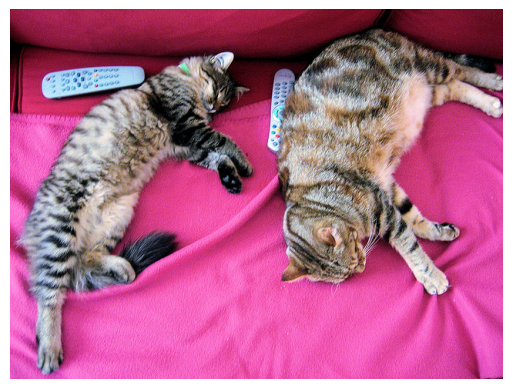

In [4]:
# Plot the image
plt.imshow(image)
plt.axis("off")

In [5]:
# Start of an input string

str_start = "The animal on the picture is a type of"



In [6]:
# Initialize a GPT model (previous day exercise) 

In [7]:
model_type = 'gpt2'
model = GPT.from_pretrained(model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We move the model to device in case we want to exploit gpu acceleration
# we also set it to eval mode since we are not interested in computing or storing any gradients
model.to(device)
model.eval();

number of parameters: 124.44M


In [8]:
str_comp = model.prompt_topK(str_start, 1, 5)

--------------------------------------------------------------------------------
The animal on the picture is a type of cat
--------------------------------------------------------------------------------
The animal on the picture is a type of rabbit
--------------------------------------------------------------------------------
The animal on the picture is a type of dog
--------------------------------------------------------------------------------
The animal on the picture is a type of black
--------------------------------------------------------------------------------
The animal on the picture is a type of p


# Load the CLIP model

In [10]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [11]:
# Choose device dynamically
model = model.to(device)

In [12]:
# easier than having `with torch.no_grad` everywhere
for p in model.parameters():
    p.requires_grad = False

In [13]:
model.device

device(type='cuda', index=0)

In [14]:
# Load existing image processor
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [15]:
# Convert the image using the processor
# Show the raw pixel values
image_inputs = processor([image], return_tensors="pt")
image_inputs["pixel_values"]

tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],

         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0.8545],
          [-0.4137, -0.4706, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

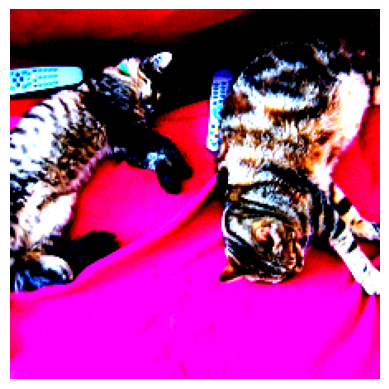

In [16]:
# Plot the image after processing
plt.imshow(image_inputs["pixel_values"].squeeze().transpose(0,2).transpose(0,1))
plt.axis("off")

In [17]:
# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [18]:
# Tokenize the text generated by gpt2
text_inputs=tokenizer(str_comp, return_tensors="pt", truncation=True, padding="longest")

In [19]:
for k,v in text_inputs.items():
    text_inputs[k]=v.to(model.device)

In [20]:
for k,v in image_inputs.items():
    image_inputs[k]=v.to(model.device)

In [21]:
text_embedding = model.text_model(**text_inputs).pooler_output

In [36]:
# This should be a function


pixel_values = image_inputs["pixel_values"]
batch_size, _, height, width = pixel_values.shape
target_dtype = model.vision_model.embeddings.patch_embedding.weight.dtype
patch_embeds = model.vision_model.embeddings.patch_embedding(pixel_values.to(dtype=target_dtype))  # shape = [*, width, grid, grid]
patch_embed_flat = patch_embeds.flatten(2).transpose(1, 2)

class_embeds = model.vision_model.embeddings.class_embedding.expand(batch_size, 1, -1)
hidden_states = torch.cat([class_embeds, patch_embed_flat], dim=1)
hidden_states = hidden_states + model.vision_model.embeddings.position_embedding(model.vision_model.embeddings.position_ids)

# this does it in one line
#hidden_states = model.vision_model.embeddings(image_inputs["pixel_values"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6920661..0.8354542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7070738..0.9668401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7220815..2.1316772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0463567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..0.9514116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.2500329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.792262

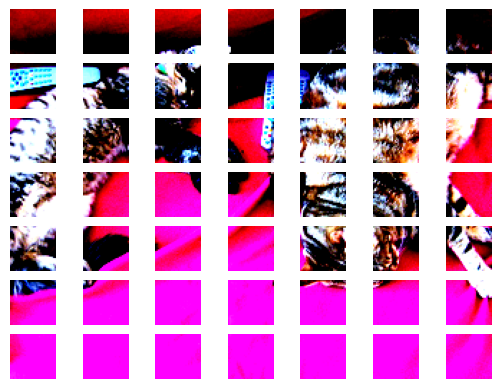

In [37]:
assert height==width
patch_size=model.vision_model.embeddings.patch_size
num_patches = width//patch_size
fig,axes = plt.subplots(num_patches, num_patches)
image_to_plot = pixel_values[0].transpose(0,2).transpose(0,1).cpu()
for i in range(num_patches):
    for j in range(num_patches):
        axes[i,j].imshow(image_to_plot[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size])
        axes[i,j].axis("off")

In [38]:
manual_conv = torch.zeros(num_patches, num_patches,device=model.device)
first_filter_weight=model.vision_model.embeddings.patch_embedding.weight[0].reshape(-1)
for i in range(num_patches):
    for j in range(num_patches):
        manual_conv[i,j]=pixel_values[0,:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size].reshape(-1)@first_filter_weight

In [39]:
assert torch.isclose(manual_conv,patch_embeds[0,0],atol=1e-3).all()

In [40]:
manual_conv

tensor([[ 0.1563,  0.2167,  0.0700,  0.2983, -0.0587,  0.4001, -0.1399],
        [-1.1652,  1.0278,  1.0702,  0.0928, -0.1709, -0.5842,  0.1128],
        [ 0.8221,  0.0252,  0.6142,  0.9892,  0.2489,  0.4761,  1.0463],
        [-0.4725,  0.7867,  0.1147, -0.9602,  0.3285, -0.5464, -0.0221],
        [ 0.1366, -0.0588,  0.3622,  0.3515,  0.0789, -0.3064, -0.6587],
        [ 0.4915,  0.0873,  0.4238,  0.2976,  0.0313,  0.4432,  0.2797],
        [ 0.1370,  0.2782,  0.3487,  0.4768,  0.2954,  0.3028,  0.3478]],
       device='cuda:0')

In [41]:
patch_embeds[0,0]

tensor([[ 0.1564,  0.2167,  0.0701,  0.2985, -0.0587,  0.4002, -0.1400],
        [-1.1651,  1.0280,  1.0703,  0.0930, -0.1708, -0.5842,  0.1127],
        [ 0.8221,  0.0252,  0.6143,  0.9891,  0.2487,  0.4760,  1.0464],
        [-0.4724,  0.7866,  0.1147, -0.9603,  0.3284, -0.5465, -0.0220],
        [ 0.1366, -0.0588,  0.3622,  0.3517,  0.0790, -0.3065, -0.6587],
        [ 0.4914,  0.0872,  0.4237,  0.2975,  0.0311,  0.4432,  0.2796],
        [ 0.1371,  0.2782,  0.3488,  0.4767,  0.2953,  0.3026,  0.3479]],
       device='cuda:0')

In [42]:
hidden_states = model.vision_model.pre_layrnorm(hidden_states)

encoder_outputs = model.vision_model.encoder(
    inputs_embeds=hidden_states
)

last_hidden_state = encoder_outputs.last_hidden_state
pooled_output = last_hidden_state[:, 0, :]
image_embedding = model.vision_model.post_layernorm(pooled_output)

# this does it in one line
#image_embedding = model.vision_model(**image_inputs).pooler_output

In [43]:
text_embedding = model.text_projection(text_embedding)

In [44]:
image_embedding = model.visual_projection(image_embedding)

In [45]:
text_embedding/=text_embedding.norm(dim=1, keepdim=True)
image_embedding/=image_embedding.norm(dim=1, keepdim=True)

In [46]:
similarities = image_embedding@text_embedding.T

In [47]:
ranking = similarities.argsort(dim=1, descending=True)

In [48]:
assert ranking.shape[0] == 1
for i in ranking[0]:
    print(f"{str_comp[i.item()]} - {similarities[0,i].item():.3f}")

The animal on the picture is a type of dog - 0.057
The animal on the picture is a type of black - 0.052
The animal on the picture is a type of cat - 0.051
The animal on the picture is a type of p - 0.046
The animal on the picture is a type of rabbit - 0.033
